In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import gym
import d4rl

from rlkit.torch.networks import Mlp
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 10)

In [4]:
def get_bonus(obs, actions, network, target_network):
    data = torch.cat((obs, actions), dim=1)
    # print('size of data:{}'.format(data.size()))
    
    with torch.no_grad():
        bonus = abs(network(data) - target_network(data))
    # print('size of bonus:{}'.format(bonus.size()))
    
    return bonus

In [5]:
def get_bonus_random_actions(obs, actions, network, target_network):
    action_shape = actions.shape[0]
    obs_shape = obs.shape[0]
    num_repeat = int (action_shape / obs_shape)
    obs_temp = obs.unsqueeze(1).repeat(1, num_repeat, 1).view(obs.shape[0] * num_repeat, obs.shape[1])
    # feed to the bonus networks
    data = torch.cat((obs_temp, actions), dim=1)
    with torch.no_grad():
        bonus = abs(network(data) - target_network(data))
    # reshape
    bonus = bonus.view(obs.shape[0], num_repeat, 1)
    return bonus

In [6]:
def load_models(model_name):
    
    M = 64
    network = Mlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=[M, M],
    )

    target_network = Mlp(
    input_size=obs_dim + action_dim,
    output_size=1,
    hidden_sizes=[M, M],
    )
    
    path = '../models/{}'.format(model_name)
    checkpoint = torch.load(path, map_location='cpu')
    network.load_state_dict(checkpoint['network_state_dict'])
    target_network.load_state_dict(checkpoint['target_state_dict'])

    print('Loading model: {}'.format(path))
    
    return network, target_network

In [25]:
env_name = 'walker2d-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)
dataset = env.get_dataset()

obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']

17
6


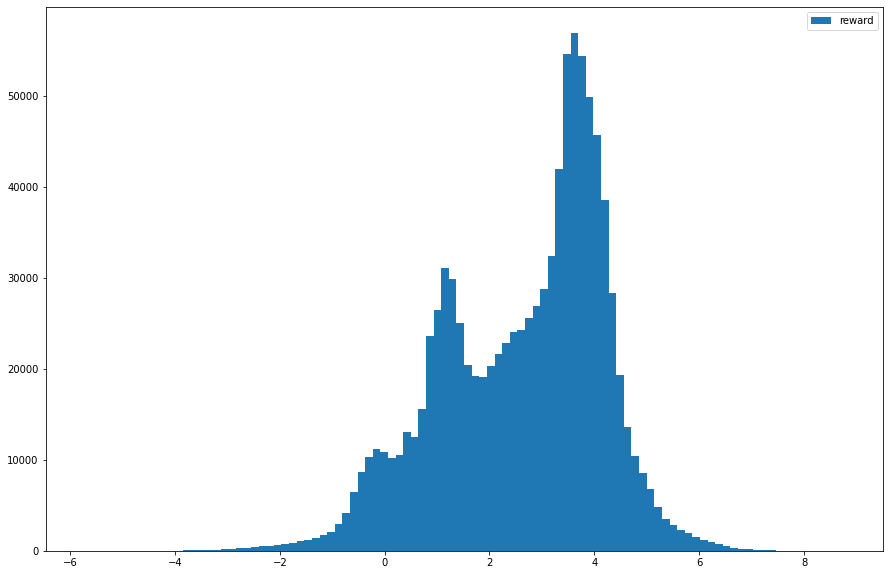

In [23]:
num_bins = 100
plt.hist(rewards, bins = num_bins, label='reward')
plt.legend()


In [26]:
print(min(rewards))
rewards = rewards - min(rewards)


-5.7413273


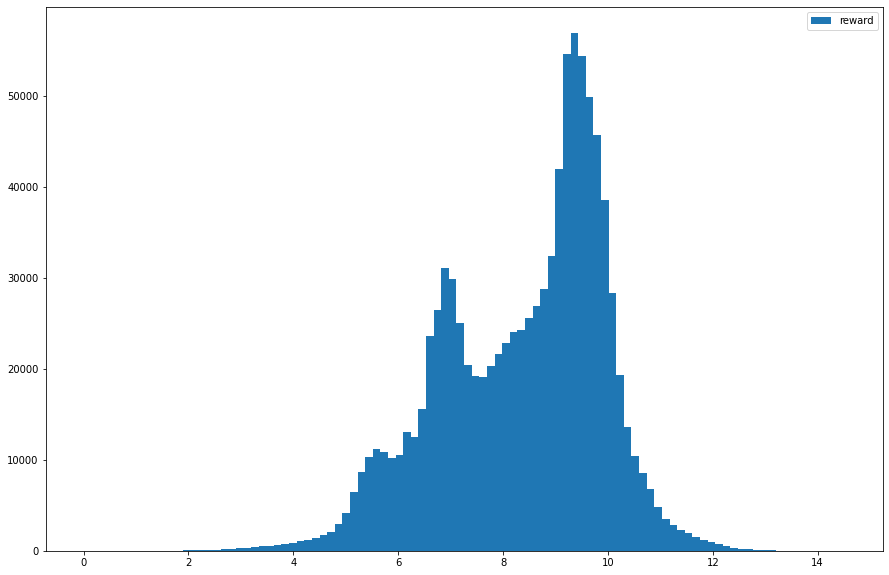

In [21]:
num_bins = 100
plt.hist(rewards, bins = num_bins, label='reward')
plt.legend()

In [11]:
env_name = 'halfcheetah-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)
dataset = env.get_dataset()

obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']

/usr/local/google/home/shideh/virtual_env/ML/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


17
6


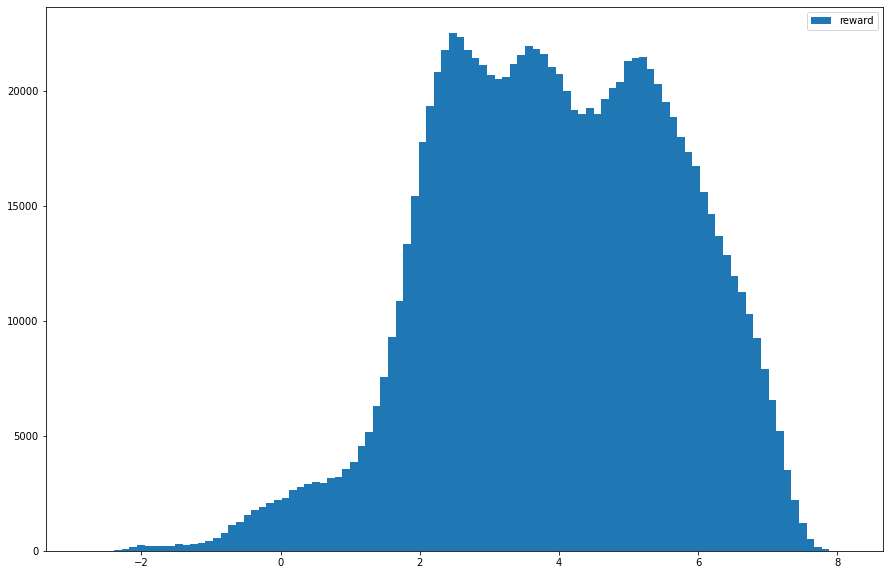

In [12]:
num_bins = 100
plt.hist(rewards, bins = num_bins, label='reward')
plt.legend()